In [ ]:
# from psutil import virtual_memory
# ram_gb = virtual_memory().total / 1e9
# print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

# from tensorflow.python.client import device_lib
# def get_available_gpus():
#     local_device_protos = device_lib.list_local_devices()
#     return [x.name for x in local_device_protos if x.device_type == 'GPU']

# gpu_info = !nvidia-smi
# gpu_info = '\n'.join(gpu_info)
# if gpu_info.find('failed') >= 0:
#     print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
#     print('and then re-execute this cell.')
# else:
#     print(gpu_info)

# print('\nAvailable GPUs:', get_available_gpus())

In [ ]:
# import os
# folder_path = '/content/drive/MyDrive'
# for filename in os.listdir(folder_path):
#     if filename.endswith(".jpg"):
#         os.remove(os.path.join(folder_path, filename))


#DownLoad Dataset

In [ ]:
# from google.colab import files
# uploaded = files.upload()

In [ ]:
# !mkdir -p ~/.kaggle
# !mv kaggle.json ~/.kaggle/

In [ ]:
# !chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# !kaggle datasets download -d quandang/vietnamese-foods

In [ ]:
# !unzip /content/drive/MyDrive/Data/data_hocsau/data_hocsau-20240224T094748Z-001.zip

https://github.com/ds4v/30VNFoods/blob/main/Model%20Implement/VGG19/VGG19.ipynb

https://www.kaggle.com/datasets/quandang/vietnamese-foods/data

#GET STATED

DepthWise Conv + DepthWise-Separable Conv: https://www.youtube.com/watch?v=vVaRhZXovbw

Paper EfficientNet: https://arxiv.org/abs/1905.11946

Paper Swish (SiLU): https://arxiv.org/pdf/1710.05941.pdf)

Paper SE block: https://arxiv.org/pdf/1709.01507.pdf

Paper MB block: https://arxiv.org/pdf/1801.04381v4.pdf

In [ ]:
from tensorflow.keras.layers import Conv2D, DepthwiseConv2D, BatchNormalization, Dense, MaxPooling2D, GlobalAveragePooling2D, Dropout
from tensorflow.keras.layers import Input, Rescaling, Normalization, Activation, Reshape, multiply, add, Flatten
from tensorflow.keras.optimizers import SGD
import math
import copy
import numpy as np
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt

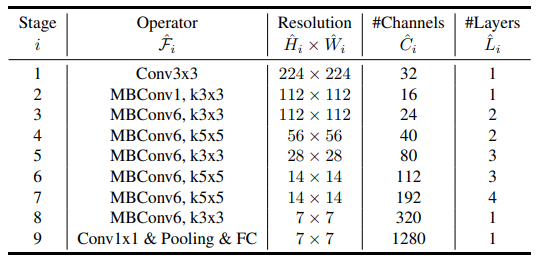

#define

In [ ]:
DEFAULT_BLOCKS_ARGS = [
    {
        "kernel_size": 3,
        "repeats": 1,
        "filters_in": 32,
        "filters_out": 16,
        "expand_ratio": 1,
        "id_skip": True,
        "strides": 1,
        "se_ratio": 0.25,
    },
    {
        "kernel_size": 3,
        "repeats": 2,
        "filters_in": 16,
        "filters_out": 24,
        "expand_ratio": 6,
        "id_skip": True,
        "strides": 2,
        "se_ratio": 0.25,
    },
    {
        "kernel_size": 5,
        "repeats": 2,
        "filters_in": 24,
        "filters_out": 40,
        "expand_ratio": 6,
        "id_skip": True,
        "strides": 2,
        "se_ratio": 0.25,
    },
    {
        "kernel_size": 3,
        "repeats": 3,
        "filters_in": 40,
        "filters_out": 80,
        "expand_ratio": 6,
        "id_skip": True,
        "strides": 2,
        "se_ratio": 0.25,
    },
    {
        "kernel_size": 5,
        "repeats": 3,
        "filters_in": 80,
        "filters_out": 112,
        "expand_ratio": 6,
        "id_skip": True,
        "strides": 1,
        "se_ratio": 0.25,
    },
    {
        "kernel_size": 5,
        "repeats": 4,
        "filters_in": 112,
        "filters_out": 192,
        "expand_ratio": 6,
        "id_skip": True,
        "strides": 2,
        "se_ratio": 0.25,
    },
    {
        "kernel_size": 3,
        "repeats": 1,
        "filters_in": 192,
        "filters_out": 320,
        "expand_ratio": 6,
        "id_skip": True,
        "strides": 1,
        "se_ratio": 0.25,
    },
]

phi_values = {
    # phi_value, resolution, drop_rate
    "b0": (0,224,0.2),
    "b1": (0.5,240,0.2),
    "b2": (1,260,0.3),
    "b3": (2,300,0.3),
    "b4": (3,380,0.4),
    "b5": (4,456,0.4),
    "b6": (5,528,0.5),
    "b7": (6,600,0.5)
}

CONV_KERNEL_INITIALIZER = {
    "class_name": "VarianceScaling",
    "config": {
        "scale": 2.0,
        "mode": "fan_out",
        "distribution": "truncated_normal",
    },
}

## Cài hàm Swish activation (SiLU)

In [ ]:
import tensorflow as tf
def Swish(x):
  return x * tf.nn.sigmoid(x)

##Cài hàm CNN Block

In [ ]:
def CNNBlock(x, in_channels, out_channels, kernel_size, stride=1, groups=1):
  x = Conv2D(filters=out_channels,
             kernel_size=kernel_size,
             padding='same',
             strides=stride,
             groups=groups    # depthwise (if groups = in_channel),
             )(x)
  x = BatchNormalization()(x)
  x = Swish(x)
  return x

##Cài hàm Squeeze-and-Excitation (SE) block

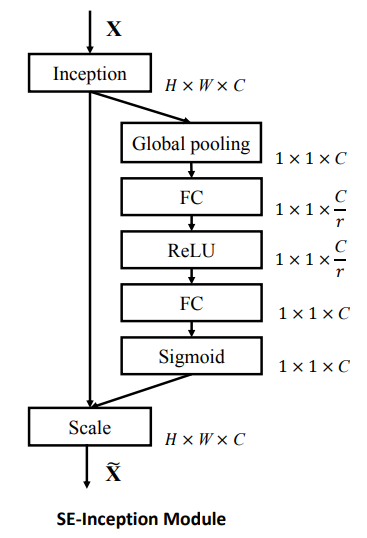

In [ ]:
from tensorflow.keras.layers import Reshape

def SqueezeExcitation(x, in_channels, reduced_dim):
  skip = x
  x = GlobalAveragePooling2D()(x)
  x = Reshape((1, 1, -1))(x)  # Thay đổi hình dạng của tensor thành (1, 1, channels)
  x = Conv2D(filters=reduced_dim, kernel_size=(1,1), strides=1)(x)
  x = Swish(x)
  x = Conv2D(filters=in_channels, kernel_size=(1,1), strides=1)(x)
  x = tf.keras.activations.sigmoid(x)

  x = add([skip, x])
  return x

##Cài hàm MB InvertedResidualBlock

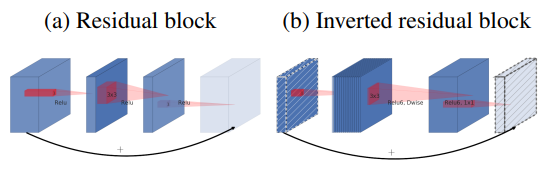

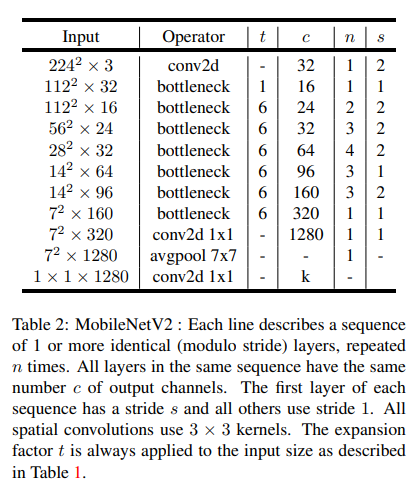

In [ ]:
def InvertedResidualBlock(x, in_channels, out_channels, kernel_size, stride, expand_ratio, reduction=4, survival_prob=0.8):
  shortcut = x
  use_redual = (in_channels == out_channels and stride==1)
  hidden_dim = int(in_channels * expand_ratio)                 # @@@@
  expand = (in_channels != hidden_dim)  # only expand in-between the stage
  reduced_dim = int(in_channels / reduction)

  if expand:
    x = CNNBlock(x, in_channels, hidden_dim, kernel_size=3, stride=1)

  x = CNNBlock(x, hidden_dim, hidden_dim, kernel_size, stride, groups=hidden_dim)
  x = SqueezeExcitation(x, hidden_dim, reduced_dim)
  x = Conv2D(filters=out_channels, kernel_size=(1,1))(x)
  x = BatchNormalization()(x)

  if use_redual:
    x = Dropout(survival_prob)(x)
    x = tf.keras.layers.add([shortcut, x])

  return x

#Load Data

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.utils import image_dataset_from_directory

In [ ]:
class_names = ['Bánh Mì', 'Bánh Xèo', 'Bún Bò Huế', 'Bún Riêu', 'Cháo Lòng']

In [ ]:
TRAIN_PATH = '/content/drive/MyDrive/Data/data_hocsau/data_hocsau/Images/Train'
VALIDATE_PATH = '/content/drive/MyDrive/Data/data_hocsau/data_hocsau/Images/Validate'
TEST_PATH = '/content/drive/MyDrive/Data/data_hocsau/data_hocsau/Images/Test'
IMAGE_SIZE = (380,380)
BATCH_SIZE = 16

In [ ]:
train_dataset = image_dataset_from_directory(TRAIN_PATH,
                                             image_size=IMAGE_SIZE,
                                             batch_size=BATCH_SIZE,
                                             label_mode='int')
test_dataset = image_dataset_from_directory(VALIDATE_PATH,
                                             image_size=IMAGE_SIZE,
                                             batch_size=BATCH_SIZE,
                                             label_mode='int')
valid_dataset = image_dataset_from_directory(TEST_PATH,
                                             image_size=IMAGE_SIZE,
                                             batch_size=BATCH_SIZE,
                                             label_mode='int')

Found 4383 files belonging to 5 classes.
Found 625 files belonging to 5 classes.
Found 1255 files belonging to 5 classes.


##Visualization Data

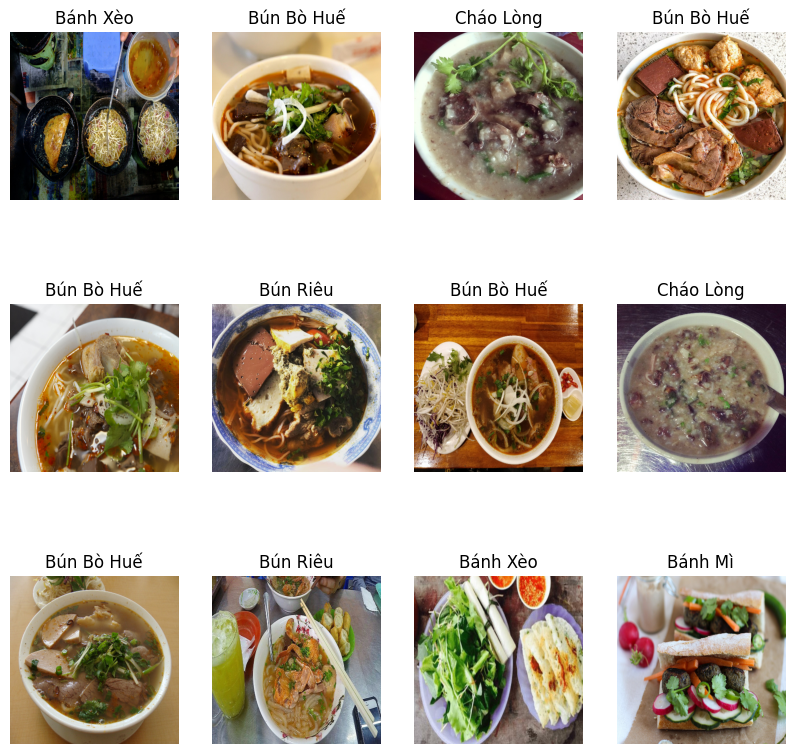

In [ ]:
for image, label in train_dataset:
  plt.figure(figsize=(10,10))
  for i in range(12):
    plt.subplot(3,4, i+1)
    plt.imshow(image[i].numpy().astype('uint8'))
    plt.title(f"{class_names[label[i]]}")
    plt.axis('off')
  plt.show()
  break

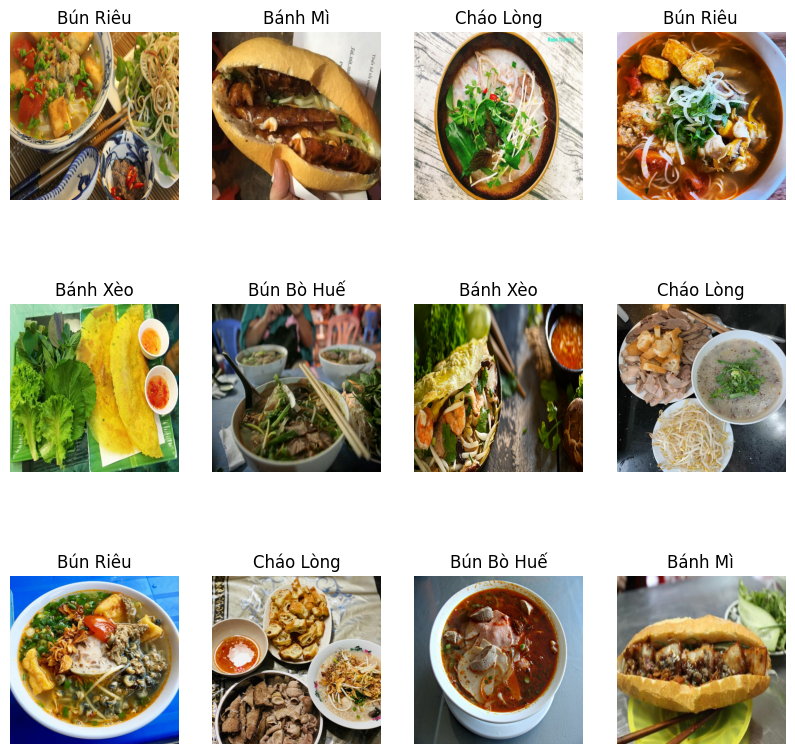

In [ ]:
for image, label in valid_dataset:
  plt.figure(figsize=(10,10))
  for i in range(12):
    plt.subplot(3,4, i+1)
    plt.imshow(image[i].numpy().astype('uint8'))
    plt.title(f"{class_names[label[i]]}")
    plt.axis('off')
  plt.show()
  break

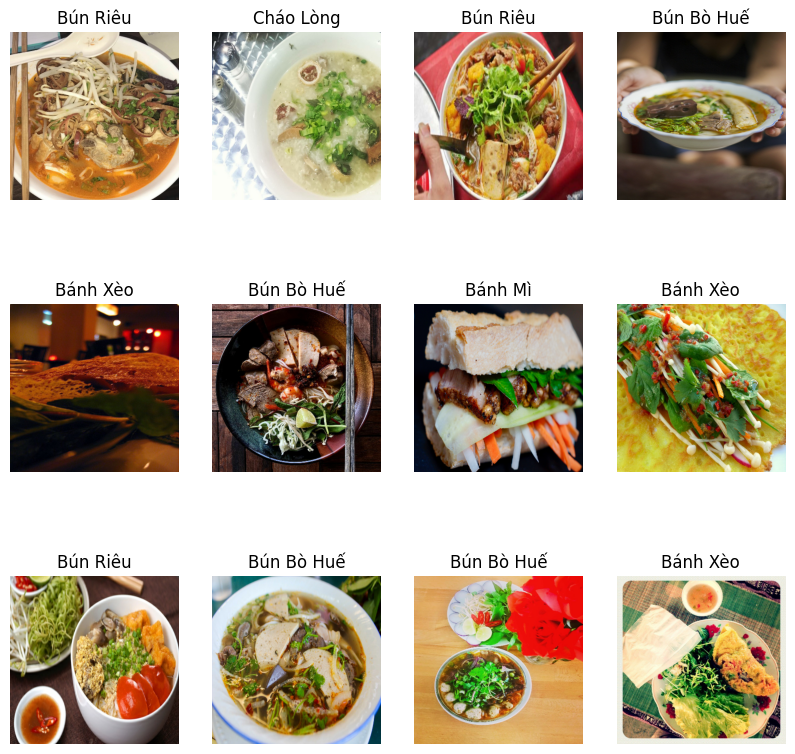

In [ ]:
for image, label in test_dataset:
  plt.figure(figsize=(10,10))
  for i in range(12):
    plt.subplot(3,4, i+1)
    plt.imshow(image[i].numpy().astype('uint8'))
    plt.title(f"{class_names[label[i]]}")
    plt.axis('off')
  plt.show()
  break

# Data AUG layers

In [ ]:
data_augmentation = Sequential(
[
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(0.2),
  layers.RandomContrast(0.2),
  layers.RandomTranslation(0.2, 0.2)
])

#Cài Mạng EfficientNet

https://github.com/keras-team/keras/blob/v2.15.0/keras/applications/efficientnet.py#L471

In [ ]:
def round_filters(filters, divisor, width_coefficient):
  filters *= width_coefficient
  new_filters = max(divisor, int(filters + divisor/2) // divisor * divisor)
  if new_filters < 0.95*filters:                                                # thay 0.9 -> 0.95
    new_filters += divisor
  return int(new_filters)

In [ ]:
def round_repeats(repearts, depth_coefficient):
  return int(math.ceil(depth_coefficient * repearts))

In [ ]:
def block(inputs, activation='swish', drop_rate=0.0,
          name="", filters_in=32, filters_out=16,
          kernel_size=3, strides=1, expand_ratio=1,
          se_ratio=0.0, id_skip=True):
  # InvertedResidual Block

  # Expansion phase
  filters = filters_in * expand_ratio
  if expand_ratio != 1:                                                         # Thực hiện tăng kích thước filters
    x = Conv2D(filters, kernel_size=(1,1), padding='same', use_bias=False,
               kernel_initializer=CONV_KERNEL_INITIALIZER, name= name + 'expand_conv')(inputs)
    x = BatchNormalization(name = name + "expand_bn")(x)
    x = Activation(activation, name = name + 'expand_activation')(x)
  else:
    x = inputs                                                                  # Nếu expand_ratio == 1 thì giữ nguyên

  # DepthWise Conv
  x = DepthwiseConv2D(kernel_size=kernel_size, strides=strides, padding='same',
                      use_bias=False, depthwise_initializer=CONV_KERNEL_INITIALIZER,
                      name = name + 'dwconv')(x)
  x = BatchNormalization()(x)
  x = Activation(activation)(x)

  # Squeeze and Excitation phase
  if 0 < se_ratio < 1:
    filters_se = max(1, int(filters_in * se_ratio))                             # Tính số filters mới (nhỏ lại) dựa vào tỉ lệ se_ratio để thực hiện SE phase
    se = GlobalAveragePooling2D(name = name + "se_squeeze")(x)
    se_shape = (1,1,filters)
    se = Reshape(se_shape, name = name + "se_reshape")(se)
    se = Conv2D(filters_se, kernel_size=(1,1), padding='same', strides=1,
                activation=activation, kernel_initializer=CONV_KERNEL_INITIALIZER,
                name = name + "se_reduce")(se)
    se = Conv2D(filters, kernel_size=(1,1), padding='same', strides=1,          # To ra trở về ban đầu
                activation='sigmoid', kernel_initializer=CONV_KERNEL_INITIALIZER,
                name = name + "se_expand")(se)
    x = multiply([x, se], name = name + 'se_excite')                            # Nhân vào của SE

    # Output phase
    x = Conv2D(filters_out, kernel_size=(1,1), padding='same', use_bias=False,
               kernel_initializer=CONV_KERNEL_INITIALIZER, name = name + "output_phase")(x)
    x = BatchNormalization()(x)

    if id_skip and strides == 1 and filters_in == filters_out:
      if drop_rate > 0:
        x = Dropout(drop_rate)(x)
      x = add([x, inputs], name=name+"_add")                                    # Add của Inverted Res

    return x

In [ ]:
def EfficientNet_moi(width_coefficient,
                    depth_coefficient,
                    default_size,
                    drop_connect_rate=0.2,
                    depth_divisor=8,
                    activation="swish",
                    classes = 5,
                    activation_top = 'softmax'
                    ):
  img_input = Input((default_size, default_size, 3))
  x = data_augmentation(img_input)
  x = Rescaling(1.0 / 255.0)(x)
  x = Normalization()(x)
  x = Conv2D(filters=round_filters(32, depth_divisor, width_coefficient), kernel_size=3, strides=2, padding='same',
             kernel_initializer=CONV_KERNEL_INITIALIZER,name="stem_conv")(x)
  x = BatchNormalization()(x)
  x = Activation('swish')(x)

  # Build blocks
  blocks_args = copy.deepcopy(DEFAULT_BLOCKS_ARGS)
  b = 0
  blocks = float(sum(round_repeats(args["repeats"], depth_coefficient) for args in blocks_args))  # Tính tổng số lượng layers dựa vào chỉ số chiều sâu
  for i, args in enumerate(blocks_args):
    assert args['repeats'] > 0
    # Cập nhật filter dựa trên hệ số chiều rộng
    args["filters_in"] = round_filters(args["filters_in"], depth_divisor, width_coefficient)
    args["filters_out"] = round_filters(args["filters_out"], depth_divisor, width_coefficient)

    for j in range(round_repeats(args.pop('repeats'), depth_coefficient)):      # Pop là lấy phần tử ra và xoá nó khỏi ds
      if j > 0:                                                                 # Kể từ block thứ 2
        args['strides'] = 1
        args['filters_in']= args['filters_out']
        ##
      name = f"block{i + 1}{chr(j+97)}_"
      x = block(x, activation, drop_connect_rate*b / blocks, name,
                args['filters_in'], args['filters_out'], args['kernel_size'],
                args['strides'], args['expand_ratio'], args['se_ratio'], args['id_skip'])
      b += 1

  # Layer cuối cùng
  x = Conv2D(round_filters(1280, depth_divisor, width_coefficient), kernel_size=(1,1), padding='same', use_bias=False,
             kernel_initializer=CONV_KERNEL_INITIALIZER, name='top_conv')(x)
  x = BatchNormalization()(x)
  x = Activation(activation, name='top_activation')(x)

  # FC
  x = GlobalAveragePooling2D(name='avg_top_pool')(x)
  x = BatchNormalization()(x)
  x = Dense(256, activation='relu')(x)
  x = Dropout(0.5)(x)

  outputs= Dense(classes, activation=activation_top)(x)
  model = Model(inputs=img_input, outputs=outputs)

  return model

In [ ]:
def calculate_factors(version, alpha=1.2, beta=1.1):
  phi, res, drop_rate = phi_values[version]
  depth_factor = alpha ** phi
  width_factor = beta ** phi
  return width_factor, depth_factor, res, drop_rate

In [ ]:
model = EfficientNet_moi(*calculate_factors('b4'), classes=5, activation_top='softmax')
model.summary()

##Train Model

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
ckpoint = ModelCheckpoint('/content/drive/MyDrive/Data/model_trained/best_weight_EffNet_code.hdf5', monitor='val_acc',
                          save_best_only=True, verbose=1)

# model.compile(optimizer=SGD(learning_rate=0.01, momentum=0.9), loss='sparse_categorical_crossentropy', metrics='acc')
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='acc')

In [ ]:
hist = model.fit(train_dataset, epochs=30, validation_data=valid_dataset, callbacks=[ckpoint])

Epoch 1/20
274/274 [==============================] - ETA: 0s - loss: 4.2455 - acc: 0.2256
Epoch 1: val_acc improved from -inf to 0.23360, saving model to /content/drive/MyDrive/Data/model_trained/best_weight_EffNet_code.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


274/274 [==============================] - 320s 982ms/step - loss: 4.2455 - acc: 0.2256 - val_loss: 8.5000 - val_acc: 0.2336
Epoch 2/20
274/274 [==============================] - ETA: 0s - loss: 1.5778 - acc: 0.2722
Epoch 2: val_acc did not improve from 0.23360
274/274 [==============================] - 263s 952ms/step - loss: 1.5778 - acc: 0.2722 - val_loss: 15.2167 - val_acc: 0.2176
Epoch 3/20
274/274 [==============================] - ETA: 0s - loss: 1.5741 - acc: 0.2809
Epoch 3: val_acc improved from 0.23360 to 0.29600, saving model to /content/drive/MyDrive/Data/model_trained/best_weight_EffNet_code.hdf5
274/274 [==============================] - 267s 969ms/step - loss: 1.5741 - acc: 0.2809 - val_loss: 1.6542 - val_acc: 0.2960
Epoch 4/20
274/274 [==============================] - ETA: 0s - loss: 1.4924 - acc: 0.3363
Epoch 4: val_acc did not improve from 0.29600
274/274 [==============================] - 263s 955ms/step - loss: 1.4924 - acc: 0.3363 - val_loss: 1.9016 - val_acc: 0.2

In [ ]:
loss, acc = model.evaluate(test_dataset,batch_size=16, verbose=False)
print(f"\nTest accuracy: {acc*100}")


Test accuracy: 42.071712017059326


In [ ]:
model.load_weights('/content/drive/MyDrive/Data/model_trained/best_weight_EffNet_code.hdf5')

In [ ]:
loss, acc = model.evaluate(test_dataset,batch_size=16, verbose=False)
print(f"\nTest accuracy: {acc*100}")


Test accuracy: 42.071712017059326


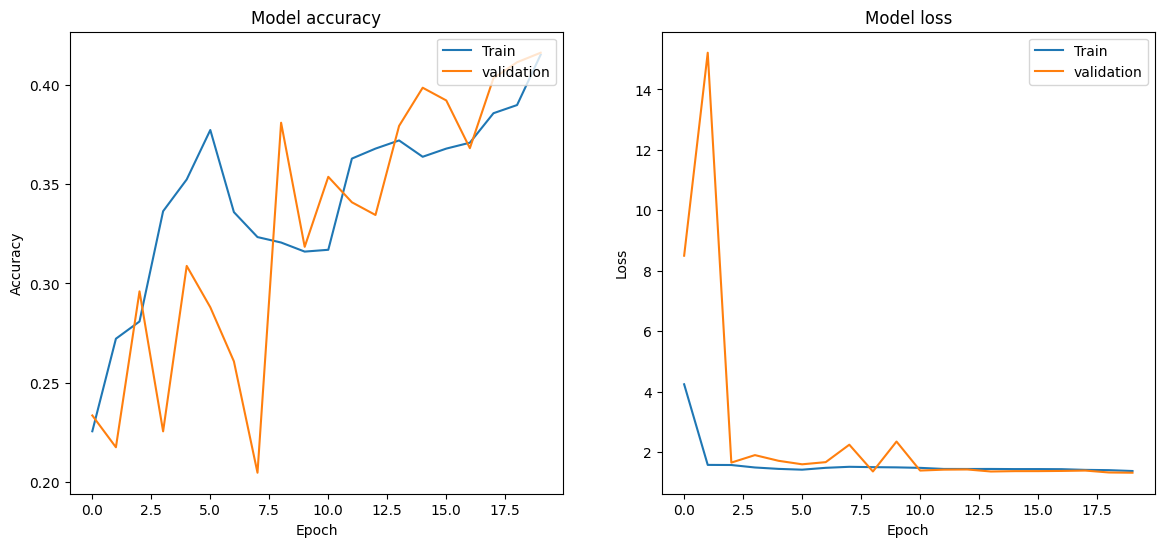

In [ ]:
import matplotlib.pyplot as plt
# Vẽ biểu đồ huấn luyện
plt.figure(figsize=(14, 6))
plt.subplot(121)
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'validation'], loc='upper right')

plt.subplot(122)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'validation'], loc='upper right')
plt.show()

#EfficentNet transfer-learning

In [ ]:
from tensorflow.keras.applications.efficientnet import preprocess_input, decode_predictions

In [ ]:
import tensorflow as tf
base_model = tf.keras.applications.efficientnet.EfficientNetB4(include_top=False,
                                                               weights=None,
                                                               input_shape=(380,380, 3),
                                                               pooling='avg'
                                                               )

base_model.trainable=True
# Fine-tuning
num_layers = len(base_model.layers)
num_layers_finetune = int(len(base_model.layers)*0.5)
print(f"Đóng băng {num_layers_finetune} layers trong tổng số {num_layers} của model EFFB04")
# Freeze
for model_layer in base_model.layers[:num_layers-num_layers_finetune]:
  model_layer.trainable = False

Đóng băng 237 layers trong tổng số 475 của model EFFB04


In [ ]:
inputs = Input(shape=(380,380,3))
x = preprocess_input(inputs)
x = base_model(x)
x = BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
outputs= Dense(10, activation='softmax')(x)

model_tras = Model(inputs = inputs, outputs=outputs)

In [ ]:
model_tras.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 380, 380, 3)]     0         
                                                                 
 efficientnetb4 (Functional  (None, 1792)              17673823  
 )                                                               
                                                                 
 batch_normalization (Batch  (None, 1792)              7168      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 256)               459008    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                2570  

##Train Model

In [ ]:
model_tras.load_weights('/content/drive/MyDrive/Data/model_trained/best_weight_EffNet_trans.hdf5')

In [ ]:
# model_tras.get_weights()

In [ ]:
# loss, acc = model_tras.evaluate(test_dataset,batch_size=16, verbose=False)
# print(f"\nTest accuracy: {acc*100}")

In [ ]:
# loss, acc = model_tras.evaluate(test_dataset,batch_size=16, verbose=False)
# print(f"\nTest accuracy: {acc*100}")

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
ckpoint = ModelCheckpoint('/content/drive/MyDrive/Data/model_trained/best_weight_EffNet_trans.hdf5', monitor='val_acc',
                          save_best_only=True, verbose=1)

# model_tras.compile(optimizer=SGD(learning_rate=0.01, momentum=0.9), loss='sparse_categorical_crossentropy', metrics='acc')
model_tras.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='acc')

In [ ]:
hist = model_tras.fit(train_dataset, epochs=20, validation_data=valid_dataset, callbacks=[ckpoint])

Epoch 1/20
274/274 [==============================] - ETA: 0s - loss: 0.8784 - acc: 0.6744
Epoch 1: val_acc improved from -inf to 0.69120, saving model to /content/drive/MyDrive/Data/model_trained/best_weight_EffNet_trans.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


274/274 [==============================] - 581s 2s/step - loss: 0.8784 - acc: 0.6744 - val_loss: 0.8548 - val_acc: 0.6912
Epoch 2/20
274/274 [==============================] - ETA: 0s - loss: 0.8727 - acc: 0.6710
Epoch 2: val_acc did not improve from 0.69120
274/274 [==============================] - 134s 482ms/step - loss: 0.8727 - acc: 0.6710 - val_loss: 0.9785 - val_acc: 0.6240
Epoch 3/20
274/274 [==============================] - ETA: 0s - loss: 1.0221 - acc: 0.6188
Epoch 3: val_acc did not improve from 0.69120
274/274 [==============================] - 135s 484ms/step - loss: 1.0221 - acc: 0.6188 - val_loss: 1.0859 - val_acc: 0.5728
Epoch 4/20
274/274 [==============================] - ETA: 0s - loss: 0.9880 - acc: 0.6094
Epoch 4: val_acc did not improve from 0.69120
274/274 [==============================] - 135s 486ms/step - loss: 0.9880 - acc: 0.6094 - val_loss: 0.9325 - val_acc: 0.6336
Epoch 5/20
274/274 [==============================] - ETA: 0s - loss: 0.9035 - acc: 0.6518
E

In [ ]:
loss, acc = model_tras.evaluate(test_dataset,batch_size=16, verbose=False)
print(f"\nTest accuracy: {acc*100}")


Test accuracy: 67.25099682807922


In [ ]:
model_tras.load_weights('/content/drive/MyDrive/Data/model_trained/best_weight_EffNet_trans.hdf5')

In [ ]:
loss, acc = model_tras.evaluate(test_dataset,batch_size=16, verbose=False)
print(f"\nTest accuracy: {acc*100}")


Test accuracy: 67.25099682807922


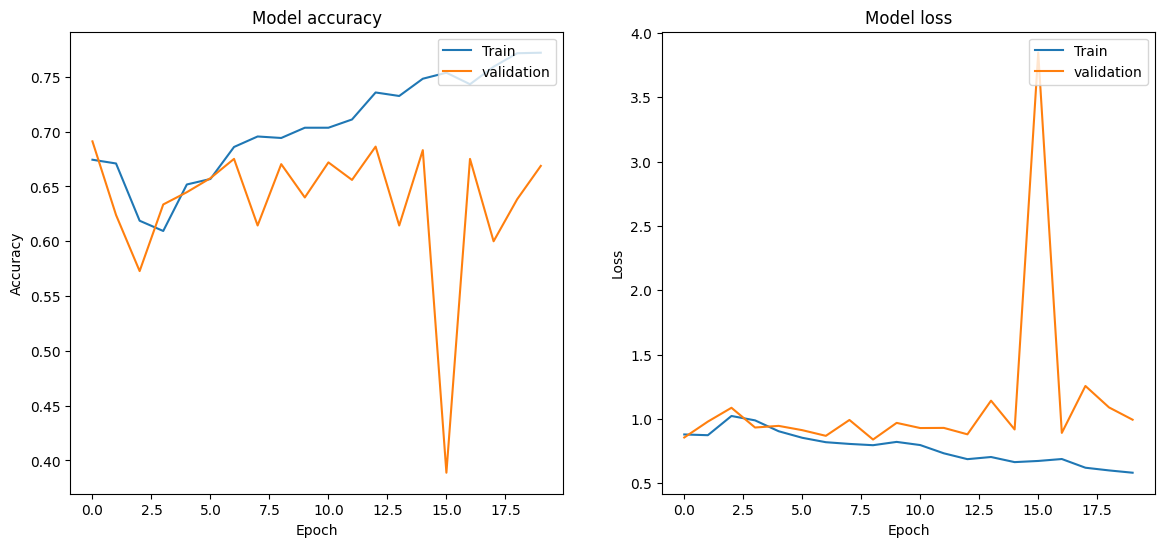

In [ ]:
import matplotlib.pyplot as plt
# Vẽ biểu đồ huấn luyện
plt.figure(figsize=(14, 6))
plt.subplot(121)
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'validation'], loc='upper right')

plt.subplot(122)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'validation'], loc='upper right')
plt.show()

#Res50 transfer-learning

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input

In [ ]:
import tensorflow as tf
base_model2 = tf.keras.applications.resnet50.ResNet50(include_top=False, input_shape=(380,380,3),
                                                      pooling='avg')
base_model2.trainable = False
#Fine-tuning
num_layers = len(base_model2.layers)
num_layers_finetune = int(len(base_model2.layers)*0.5)
print(f"Đóng băng {num_layers_finetune} layers trong tổng số {num_layers} của model EFFB04")
# Frezee
for model_layer in base_model2.layers[:num_layers-num_layers_finetune]:
  model_layer.trainable = False

Đóng băng 88 layers trong tổng số 176 của model EFFB04


In [ ]:
from tensorflow.keras.applications.resnet50 import preprocess_input

inputs = Input(shape=(380,380,3))
x = preprocess_input(inputs)
x = base_model2(x)
x = BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
outputs= Dense(10, activation='softmax')(x)

model_tras2 = Model(inputs = inputs, outputs=outputs)
model_tras2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 380, 380, 3)]     0         
                                                                 
 tf.__operators__.getitem_2  (None, 380, 380, 3)       0         
  (SlicingOpLambda)                                              
                                                                 
 tf.nn.bias_add_2 (TFOpLamb  (None, 380, 380, 3)       0         
 da)                                                             
                                                                 
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 batch_normalization_1 (Bat  (None, 2048)              8192      
 chNormalization)                                                
                                                           

##Train Model

In [ ]:
# model_tras2.load_weights('/content/drive/MyDrive/Data/model_trained/best_weight_EffNet_trans2.hdf5')

In [ ]:
# loss, acc = model_tras2.evaluate(test_dataset,batch_size=16, verbose=False)
# print(f"\nTest accuracy: {acc*100}")

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
ckpoint = ModelCheckpoint('/content/drive/MyDrive/Data/model_trained/best_weight_EffNet_trans2.hdf5', monitor='val_acc',
                          save_best_only=True, verbose=1)

model_tras2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='acc')

In [ ]:
hist = model_tras2.fit(train_dataset, epochs=20, validation_data=valid_dataset, callbacks=[ckpoint])

Epoch 1/20
274/274 [==============================] - ETA: 0s - loss: 0.7634 - acc: 0.7880
Epoch 1: val_acc improved from -inf to 0.87040, saving model to /content/drive/MyDrive/Data/model_trained/best_weight_EffNet_trans2.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


274/274 [==============================] - 769s 3s/step - loss: 0.7634 - acc: 0.7880 - val_loss: 0.3984 - val_acc: 0.8704
Epoch 2/20
274/274 [==============================] - ETA: 0s - loss: 0.4575 - acc: 0.8647
Epoch 2: val_acc improved from 0.87040 to 0.87200, saving model to /content/drive/MyDrive/Data/model_trained/best_weight_EffNet_trans2.hdf5
274/274 [==============================] - 76s 268ms/step - loss: 0.4575 - acc: 0.8647 - val_loss: 0.4177 - val_acc: 0.8720
Epoch 3/20
274/274 [==============================] - ETA: 0s - loss: 0.3403 - acc: 0.8896
Epoch 3: val_acc improved from 0.87200 to 0.89280, saving model to /content/drive/MyDrive/Data/model_trained/best_weight_EffNet_trans2.hdf5
274/274 [==============================] - 75s 266ms/step - loss: 0.3403 - acc: 0.8896 - val_loss: 0.4171 - val_acc: 0.8928
Epoch 4/20
274/274 [==============================] - ETA: 0s - loss: 0.2683 - acc: 0.9126
Epoch 4: val_acc did not improve from 0.89280
274/274 [======================

In [ ]:
loss, acc = model_tras2.evaluate(test_dataset,batch_size=16, verbose=False)
print(f"\nTest accuracy: {acc*100}")


Test accuracy: 89.96015787124634


In [ ]:
model_tras2.load_weights('/content/drive/MyDrive/Data/model_trained/best_weight_EffNet_trans2.hdf5')

In [ ]:
loss, acc = model_tras2.evaluate(test_dataset,batch_size=16, verbose=False)
print(f"\nTest accuracy: {acc*100}")


Test accuracy: 89.56175446510315


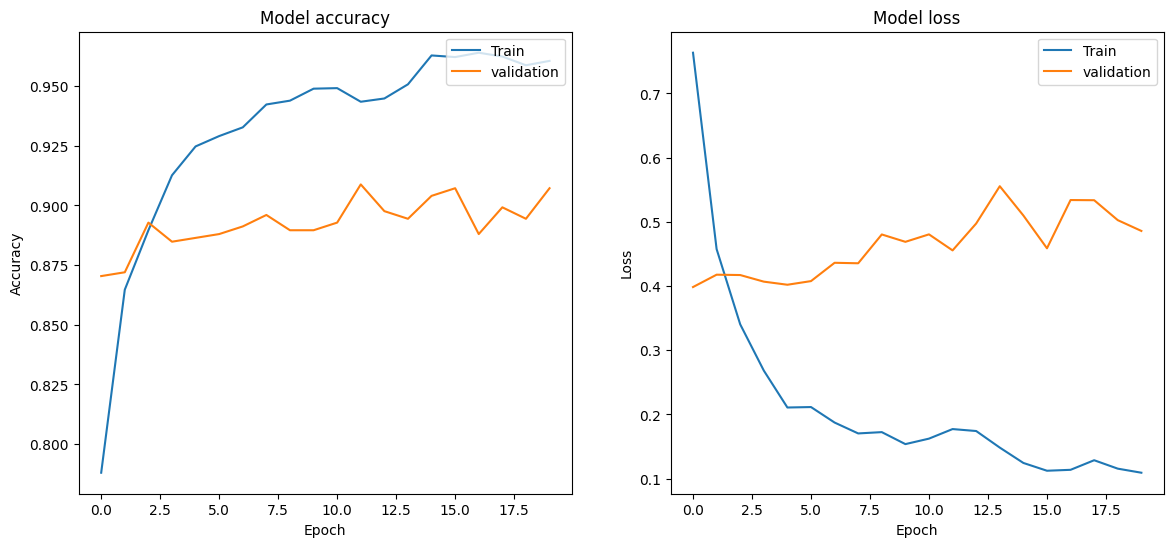

In [ ]:
import matplotlib.pyplot as plt
# Vẽ biểu đồ huấn luyện
plt.figure(figsize=(14, 6))
plt.subplot(121)
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'validation'], loc='upper right')

plt.subplot(122)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'validation'], loc='upper right')
plt.show()

#MLP

In [ ]:
model_mlp = Sequential()
model_mlp.add(Input(shape=((380, 380, 3))))
model_mlp.add(Rescaling(1.0 / 255.0))
model_mlp.add(Flatten())
model_mlp.add(Dense(units = 128, activation = 'relu'))
model_mlp.add(Dense(units = 5, activation= 'softmax'))
model_mlp.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 380, 380, 3)       0         
                                                                 
 flatten (Flatten)           (None, 433200)            0         
                                                                 
 dense (Dense)               (None, 128)               55449728  
                                                                 
 dense_1 (Dense)             (None, 5)                 645       
                                                                 
Total params: 55450373 (211.53 MB)
Trainable params: 55450373 (211.53 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


##Train Model

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
ckpoint = ModelCheckpoint('/content/drive/MyDrive/Data/model_trained/best_weight_mlp.hdf5', monitor='val_acc',
                          save_best_only=True, verbose=1)

In [ ]:
model_mlp.compile(optimizer=SGD(learning_rate=0.01, momentum=0.9), loss='sparse_categorical_crossentropy', metrics='acc')
hist = model_mlp.fit(train_dataset, epochs=20, validation_data=valid_dataset, callbacks=[ckpoint])

Epoch 1/20
274/274 [==============================] - ETA: 0s - loss: 6.1254 - acc: 0.2384

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


274/274 [==============================] - 209s 685ms/step - loss: 6.1254 - acc: 0.2384 - val_loss: 1.6012 - val_acc: 0.2448
Epoch 2/20
274/274 [==============================] - 70s 252ms/step - loss: 1.6028 - acc: 0.2418 - val_loss: 1.6012 - val_acc: 0.2448
Epoch 3/20
274/274 [==============================] - 70s 250ms/step - loss: 1.6028 - acc: 0.2444 - val_loss: 1.6011 - val_acc: 0.2448
Epoch 4/20
274/274 [==============================] - 70s 250ms/step - loss: 1.6031 - acc: 0.2444 - val_loss: 1.6012 - val_acc: 0.2448
Epoch 5/20
274/274 [==============================] - 71s 254ms/step - loss: 1.6029 - acc: 0.2407 - val_loss: 1.6013 - val_acc: 0.2448
Epoch 6/20
274/274 [==============================] - 69s 248ms/step - loss: 1.6030 - acc: 0.2444 - val_loss: 1.6013 - val_acc: 0.2448
Epoch 7/20
274/274 [==============================] - 70s 249ms/step - loss: 1.6031 - acc: 0.2423 - val_loss: 1.6012 - val_acc: 0.2448
Epoch 8/20
274/274 [==============================] - 69s 242ms/s

In [ ]:
loss, acc = model_mlp.evaluate(test_dataset,batch_size=16, verbose=False)
print(f"\nTest accuracy: {acc*100}")


Test accuracy: 24.382470548152924


In [ ]:
model_mlp.load_weights('/content/drive/MyDrive/Data/model_trained/best_weight_mlp.hdf5')

In [ ]:
loss, acc = model_mlp.evaluate(test_dataset,batch_size=16, verbose=False)
print(f"\nTest accuracy: {acc*100}")


Test accuracy: 24.382470548152924


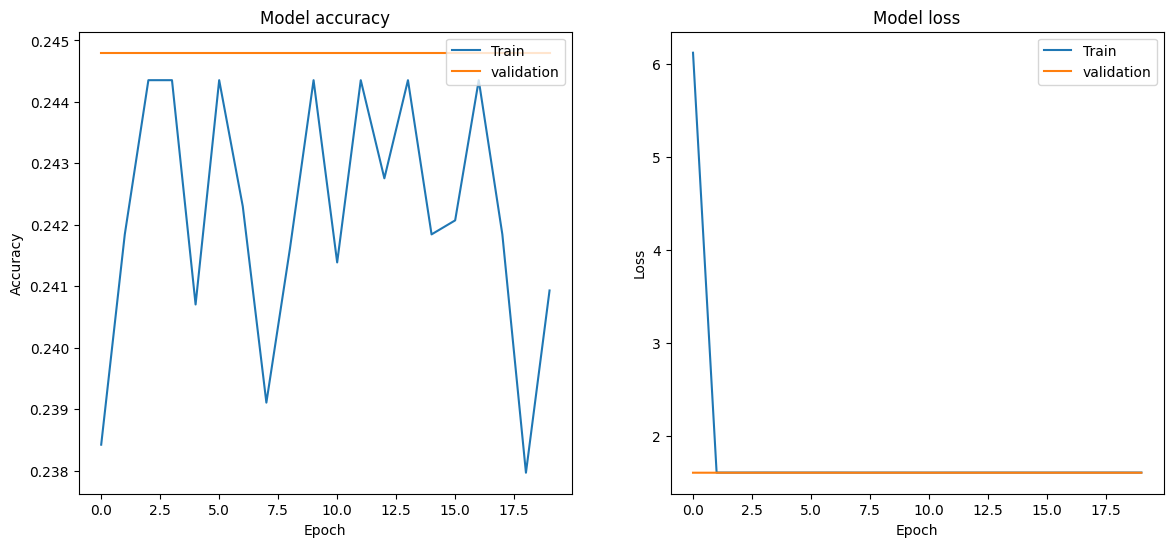

In [ ]:
import matplotlib.pyplot as plt
# Vẽ biểu đồ huấn luyện
plt.figure(figsize=(14, 6))
plt.subplot(121)
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'validation'], loc='upper right')

plt.subplot(122)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'validation'], loc='upper right')
plt.show()

#CNN

In [ ]:
model_cnn = Sequential()
model_cnn.add(Input(shape=((380, 380, 3))))
model_cnn.add(Rescaling(1.0 / 255.0))
model_cnn.add(Conv2D(32, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))
model_cnn.add(MaxPooling2D((2,2)))
model_cnn.add(Conv2D(64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))
model_cnn.add(MaxPooling2D((2,2)))
model_cnn.add(Conv2D(128, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))
model_cnn.add(MaxPooling2D((2,2)))
model_cnn.add(GlobalAveragePooling2D())
model_cnn.add(Dense(units = 256, activation= 'relu'))
model_cnn.add(Dropout(0.5))
model_cnn.add(Dense(units = 5, activation= 'softmax'))

model_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 380, 380, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 380, 380, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 190, 190, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 190, 190, 64)      18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 95, 95, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 95, 95, 128)      

##Train Model

In [ ]:
model_cnn.load_weights('/content/drive/MyDrive/Data/model_trained/best_weight_cnn.hdf5')

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
ckpoint = ModelCheckpoint('/content/drive/MyDrive/Data/model_trained/best_weight_cnn.hdf5', monitor='val_acc',
                          save_best_only=True, verbose=1)

In [ ]:
model_cnn.compile(optimizer=SGD(learning_rate=0.01, momentum=0.9), loss='sparse_categorical_crossentropy', metrics='acc')
hist = model_cnn.fit(train_dataset, epochs=20, validation_data=valid_dataset, callbacks=[ckpoint])

Epoch 1/40
274/274 [==============================] - ETA: 0s - loss: 0.7961 - acc: 0.7025
Epoch 1: val_acc improved from -inf to 0.69280, saving model to /content/drive/MyDrive/Data/model_trained/best_weight_cnn.hdf5
274/274 [==============================] - 71s 250ms/step - loss: 0.7961 - acc: 0.7025 - val_loss: 0.8059 - val_acc: 0.6928
Epoch 2/40
274/274 [==============================] - ETA: 0s - loss: 0.8002 - acc: 0.7041
Epoch 2: val_acc improved from 0.69280 to 0.71200, saving model to /content/drive/MyDrive/Data/model_trained/best_weight_cnn.hdf5
274/274 [==============================] - 68s 245ms/step - loss: 0.8002 - acc: 0.7041 - val_loss: 0.7714 - val_acc: 0.7120
Epoch 3/40
274/274 [==============================] - ETA: 0s - loss: 0.7913 - acc: 0.7032
Epoch 3: val_acc did not improve from 0.71200
274/274 [==============================] - 68s 242ms/step - loss: 0.7913 - acc: 0.7032 - val_loss: 0.8231 - val_acc: 0.6896
Epoch 4/40
274/274 [==============================] 

In [ ]:
loss, acc = model_cnn.evaluate(test_dataset,batch_size=16, verbose=False)
print(f"\nTest accuracy: {acc*100}")


Test accuracy: 75.21912455558777


In [ ]:
model_cnn.load_weights('/content/drive/MyDrive/Data/model_trained/best_weight_cnn.hdf5')

In [ ]:
loss, acc = model_cnn.evaluate(test_dataset,batch_size=16, verbose=False)
print(f"\nTest accuracy: {acc*100}")


Test accuracy: 78.80477905273438


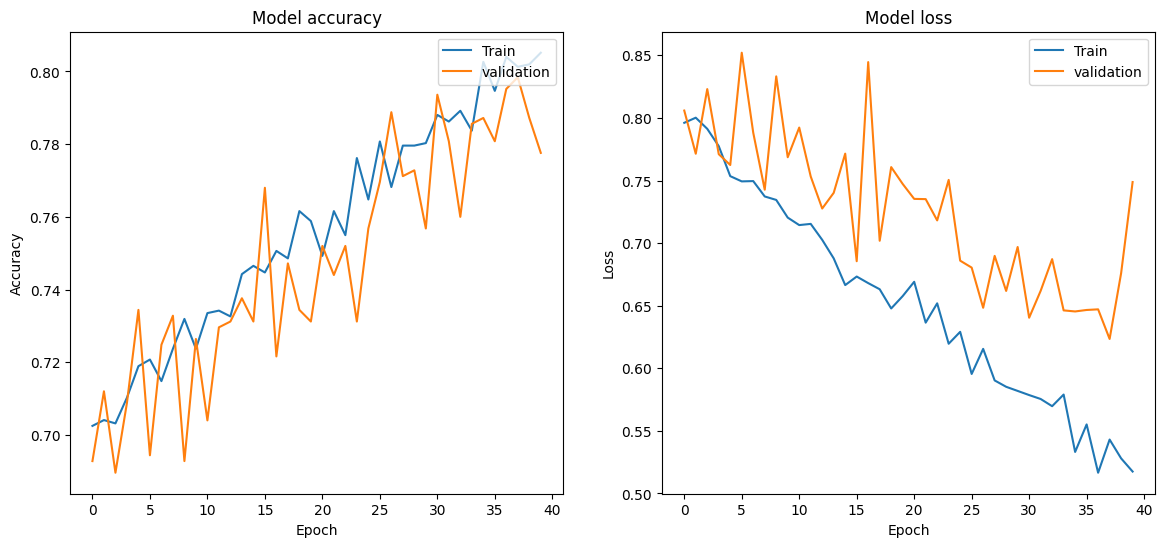

In [ ]:
import matplotlib.pyplot as plt
# Vẽ biểu đồ huấn luyện
plt.figure(figsize=(14, 6))
plt.subplot(121)
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'validation'], loc='upper right')

plt.subplot(122)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'validation'], loc='upper right')
plt.show()

#DEPLOY WITH ANVIL

In [ ]:
# !pip install anvil-uplink

In [ ]:
# import anvil.server
# anvil.server.connect('server_AFGXO4BZ5R4NFYRYH3LKZLQ5-DXJRMYRWR26QZNDQ')

In [ ]:
from tensorflow.keras.models import load_model
trained_model = load_model('/content/drive/MyDrive/Data/model_trained/best_weight_cnn.hdf5')
class_names = ['Bánh Mì', 'Bánh Xèo', 'Bún Bò Huế', 'Bún Riêu', 'Cháo Lòng']

from google.colab.patches import cv2_imshow
import cv2
import numpy as np
def get_classification(img):
  img = cv2.resize(img, (380,380))                                              # Shape 380*380*3
  img = np.expand_dims(img, axis=0)
  pred = trained_model.predict(img)
  result = class_names[np.argmax(pred)]
  return result

In [ ]:
import anvil.media
import cv2
import numpy as np
from PIL import Image
import base64, io
from anvil import BlobMedia

@anvil.server.callable
def classification(file):
  with anvil.media.TempFile(file) as f:
    img = np.array(Image.open(f))
    print(img.shape)

  result = get_classification(img)
  return result

In [ ]:
# loss, acc = trained_model.evaluate(test_dataset,batch_size=16, verbose=False)
# print(f"\nTest accuracy: {acc*100}")


Test accuracy: 71.31474018096924


In [ ]:
# anvil.server.wait_forever()

(264, 412, 3)
1/1 [==============================] - 0s 452ms/step
(264, 412, 3)
1/1 [==============================] - 0s 19ms/step
(1350, 1080, 3)
1/1 [==============================] - 0s 17ms/step
(1024, 819, 3)
1/1 [==============================] - 0s 20ms/step


KeyboardInterrupt: 